In [ ]:
from google.colab import files
uploaded=files.upload()

Saving Corpus_mun.xlsx to Corpus_mun.xlsx


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import gensim.downloader as api
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import unicodedata

In [ ]:
# Example DataFrame with Spanish text
df = pd.read_excel('Corpus_mun.xlsx')
df.head()

,ID Fiscalizacion,Numero programa,Periodo programa,Tipo Fiscalizacion,Nombre Fiscalizacion,Materia Fiscalizacion,Objetivo Fiscalizacion,ID entidad,Dependencia,Entidad,Región,Sector,Área temática,Titulo Observacion,Complejidad Observacion
0,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",No hay registro en el libro de obra acerca de ...,COMPLEJA
1,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Las instalaciones de faena no cumplen con las ...,MEDIANAMENTE COMPLEJA
2,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Ausencia de aprobaciones mediante Libro de Obras.,COMPLEJA
3,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Atraso en la entrega de la Boleta de Fiel Cump...,COMPLEJA
4,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",No se advierte que se haya efectuado un anális...,COMPLEJA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24961 entries, 0 to 24960
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID Fiscalizacion         24961 non-null  int64 
 1   Numero programa          24961 non-null  int64 
 2   Periodo programa         24961 non-null  int64 
 3   Tipo Fiscalizacion       24961 non-null  object
 4   Nombre Fiscalizacion     24961 non-null  object
 5   Materia Fiscalizacion    24956 non-null  object
 6   Objetivo Fiscalizacion   23912 non-null  object
 7   ID entidad               24961 non-null  int64 
 8   Dependencia              24961 non-null  object
 9   Entidad                  24961 non-null  object
 10  Región                   24961 non-null  object
 11  Sector                   24961 non-null  object
 12  Área temática            24961 non-null  object
 13  Titulo Observacion       24958 non-null  object
 14  Complejidad Observacion  24961 non-nul

In [ ]:
# Load Spanish stop words
stop_words = set(stopwords.words('spanish'))

# Function to remove accents from Spanish text
def remove_accents(text):
    return ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    )

# Tokenize, preprocess the text data, remove accents, and remove stop words
def preprocess(text):
    text = str(text)
    text = remove_accents(text.lower())  # Remove accents and convert to lowercase
    return [word for word in simple_preprocess(text) if word not in stop_words]

df['tokenized_text'] = df['Titulo Observacion'].apply(preprocess)

# Load fastText embeddings for Spanish (or a multilingual model)
model = api.load('fasttext-wiki-news-subwords-300')

# Function to convert a document to a vector by averaging word vectors
def document_vector(doc):
    # Filter the words that exist in the fastText model vocabulary
    words = [word for word in doc if word in model.key_to_index]
    if words:
        # Average word vectors for the document
        return np.mean([model[word] for word in words], axis=0)
    else:
        # Return a zero vector if no words in the document are in the model
        return np.zeros(model.vector_size)

# Apply document vector conversion
df['doc2vec'] = df['tokenized_text'].apply(document_vector)

# Extract document vectors into a numpy array
doc_vectors = np.array(df['doc2vec'].tolist())



[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(doc_vectors)

# Add t-SNE results to the DataFrame
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]

In [ ]:
#df.head()

,ID Fiscalizacion,Numero programa,Periodo programa,Tipo Fiscalizacion,Nombre Fiscalizacion,Materia Fiscalizacion,Objetivo Fiscalizacion,ID entidad,Dependencia,Entidad,Región,Sector,Área temática,Titulo Observacion,Complejidad Observacion,tokenized_text,doc2vec
0,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",No hay registro en el libro de obra acerca de ...,COMPLEJA,"[registro, libro, obra, acerca, aprobacion, pr...","[0.015859272, -0.033055443, -0.0134654, -0.022..."
1,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Las instalaciones de faena no cumplen con las ...,MEDIANAMENTE COMPLEJA,"[instalaciones, faena, cumplen, exigencias, no...","[-0.007444, -0.014629151, 0.00015000068, -0.06..."
2,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Ausencia de aprobaciones mediante Libro de Obras.,COMPLEJA,"[ausencia, aprobaciones, mediante, libro, obras]","[0.013738249, -0.030904027, -0.010257576, -0.0..."
3,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Atraso en la entrega de la Boleta de Fiel Cump...,COMPLEJA,"[atraso, entrega, boleta, fiel, cumplimiento, ...","[0.0073671257, -0.017416326, -0.0269331, -0.00..."
4,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",No se advierte que se haya efectuado un anális...,COMPLEJA,"[advierte, efectuado, analisis, acerca, pertin...","[0.017785266, -0.023486882, -0.0055719833, 0.0..."


In [ ]:
df['Word_l']=df['tokenized_text'].apply(lambda x: len(x))

In [ ]:
df.head()

,ID Fiscalizacion,Numero programa,Periodo programa,Tipo Fiscalizacion,Nombre Fiscalizacion,Materia Fiscalizacion,Objetivo Fiscalizacion,ID entidad,Dependencia,Entidad,Región,Sector,Área temática,Titulo Observacion,Complejidad Observacion,tokenized_text,doc2vec,Word_l
0,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",No hay registro en el libro de obra acerca de ...,COMPLEJA,"[registro, libro, obra, acerca, aprobacion, pr...","[0.015859272, -0.033055443, -0.0134654, -0.022...",9
1,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Las instalaciones de faena no cumplen con las ...,MEDIANAMENTE COMPLEJA,"[instalaciones, faena, cumplen, exigencias, no...","[-0.007444, -0.014629151, 0.00015000068, -0.06...",8
2,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Ausencia de aprobaciones mediante Libro de Obras.,COMPLEJA,"[ausencia, aprobaciones, mediante, libro, obras]","[0.013738249, -0.030904027, -0.010257576, -0.0...",5
3,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",Atraso en la entrega de la Boleta de Fiel Cump...,COMPLEJA,"[atraso, entrega, boleta, fiel, cumplimiento, ...","[0.0073671257, -0.017416326, -0.0269331, -0.00...",7
4,67853,15003,2020,INSPECCIÓN DE OBRA PÚBLICA,INSPECCION_TECNICA_OBRA DIRECCION REGIONAL DE ...,"CONTRATO: ""CONSERVACIÓN DE RIBERAS CAUCES NATU...",Realizar una inspección de obra pública al pro...,1442,DIRECCION REGIONAL DE OBRAS HIDRAULICAS ARICA ...,DIRECCION DE OBRAS HIDRAULICAS,ARICA Y PARINACOTA,SERVICIOS PUBLICOS,"Obras, Vivienda y Urbanismo",No se advierte que se haya efectuado un anális...,COMPLEJA,"[advierte, efectuado, analisis, acerca, pertin...","[0.017785266, -0.023486882, -0.0055719833, 0.0...",12


In [ ]:
df['Word_l'].describe()

,Word_l
count,24961.000000
mean,6.581187
std,5.218955
min,0.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,87.000000


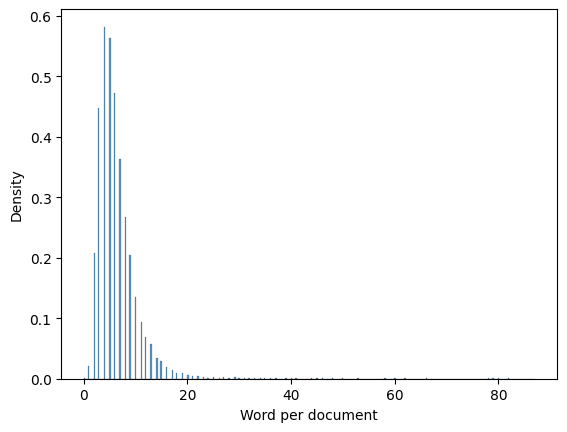

In [ ]:
import seaborn as sns
sns.histplot(df['Word_l'],  stat = 'density')
plt.xlabel('Word per document')
plt.ylabel('Density')
#plt.title('Distribution of Word per document')
plt.show()


In [ ]:
Total_text = [' '.join(w) for w in df['tokenized_text'] ]

In [ ]:
Corpus_obs=' '.join(Total_text)

In [ ]:
from nltk.tokenize.punkt import FreqDist # frecuencia de palabras
frequency = FreqDist(Corpus_obs.split())
print(frequency)

<FreqDist with 10203 samples and 164273 outcomes>


In [ ]:
frequency.most_common(21)

[('falta', 4130),
 ('ausencia', 1591),
 ('control', 1549),
 ('pago', 1091),
 ('contrato', 1034),
 ('informacion', 1033),
 ('registro', 952),
 ('sistema', 905),
 ('ii', 900),
 ('entrega', 863),
 ('cuentas', 855),
 ('servicios', 804),
 ('bienes', 791),
 ('obras', 744),
 ('respecto', 709),
 ('incumplimiento', 655),
 ('inexistencia', 653),
 ('procedimientos', 648),
 ('deficiencias', 637),
 ('cumplimiento', 631),
 ('parte', 606)]

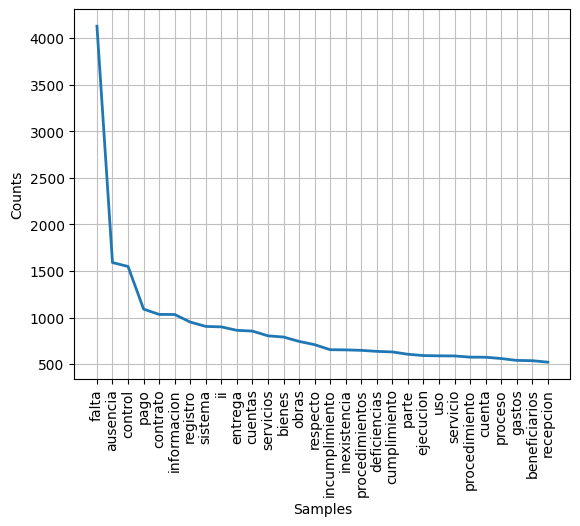

In [ ]:
frequency.plot(30,cumulative=False)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

doc_vectors = pd.DataFrame(df['doc2vec'].tolist())

# Standardize the vectors
scaler = StandardScaler()
doc_vectors_scaled = scaler.fit_transform(doc_vectors)

doc_vect_scaled_to_DF = pd.DataFrame(doc_vectors_scaled)
doc_vect_scaled_to_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.166391,-0.534771,0.289750,-1.129854,1.279902,0.805265,0.356874,0.441666,-0.146430,-0.602541,...,-0.923290,-0.805780,0.763984,0.203872,-0.244838,0.921751,0.042214,-0.492714,0.779488,0.429258
1,-0.964198,0.363798,0.925170,-2.939740,-0.597573,-0.465974,2.883708,-1.182770,-1.623683,2.123682,...,-0.955143,0.647730,-0.396298,0.025316,2.095090,-0.984728,-0.309715,-0.432308,-0.945420,-0.674890
2,0.063487,-0.429856,0.439457,-0.295208,0.248433,1.369022,-0.353014,-0.112041,0.191565,0.588574,...,-0.591092,-0.471747,0.420687,0.354881,0.069819,0.634312,-0.228559,0.369360,-0.490117,0.584272
3,-0.245617,0.227879,-0.338777,-0.447998,0.990856,-0.583203,-0.509868,-0.016472,-0.566956,-1.174664,...,-0.100474,-0.455032,0.599621,-0.142595,-0.432789,0.238567,0.249828,-0.181947,0.123258,0.225661
4,0.259833,-0.068155,0.658130,0.201623,-0.628436,-0.255734,0.570796,0.060080,-0.492049,-0.676134,...,-1.879162,0.098572,-0.538511,-1.285763,0.420207,0.528764,-0.227006,-0.232325,1.398244,0.512507


In [ ]:
from sklearn.neighbors import NearestNeighbors

def hopkins_statistic(df, sample_size=None):
    """
    Calculates the Hopkins statistic for a given pandas DataFrame.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - sample_size: Number of samples to use for the calculation. If None, 10% of the data is used.

    Returns:
    - hopkins_stat: Hopkins statistic value. A value close to 1 indicates cluster tendency.
    """
    # Convert DataFrame to NumPy array
    X = df.values

    if sample_size is None:
        sample_size = int(0.1 * X.shape[0])  # 10% of the data

    # Random sample of data points from the DataFrame
    random_indices = np.random.choice(X.shape[0], sample_size, replace=False)
    random_sample = X[random_indices]

    # Generate random points within the range of the data
    min_vals = np.min(X, axis=0)
    max_vals = np.max(X, axis=0)
    uniform_sample = np.random.uniform(min_vals, max_vals, (sample_size, X.shape[1]))

    # Nearest neighbors for random sample and uniform sample
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    u_dist, _ = nbrs.kneighbors(uniform_sample)
    w_dist, _ = nbrs.kneighbors(random_sample)

    # Calculate Hopkins statistic
    hopkins_stat = u_dist.sum() / (u_dist.sum() + w_dist.sum())
    return hopkins_stat

# ----------------------------------

hopkins_value = hopkins_statistic(doc_vect_scaled_to_DF)
print(f"Hopkins statistic: {hopkins_value}")


Hopkins statistic: 0.9999999980115248


Number of Topics: 2, Perplexity: 3287.043, Coherence Score: 0.233
Number of Topics: 3, Perplexity: 3975.119, Coherence Score: 0.336
Number of Topics: 4, Perplexity: 4674.926, Coherence Score: 0.283
Number of Topics: 5, Perplexity: 5253.288, Coherence Score: 0.287
Number of Topics: 6, Perplexity: 5865.261, Coherence Score: 0.290
Number of Topics: 7, Perplexity: 6244.201, Coherence Score: 0.330
Number of Topics: 8, Perplexity: 6860.241, Coherence Score: 0.329
Number of Topics: 9, Perplexity: 7241.864, Coherence Score: 0.349


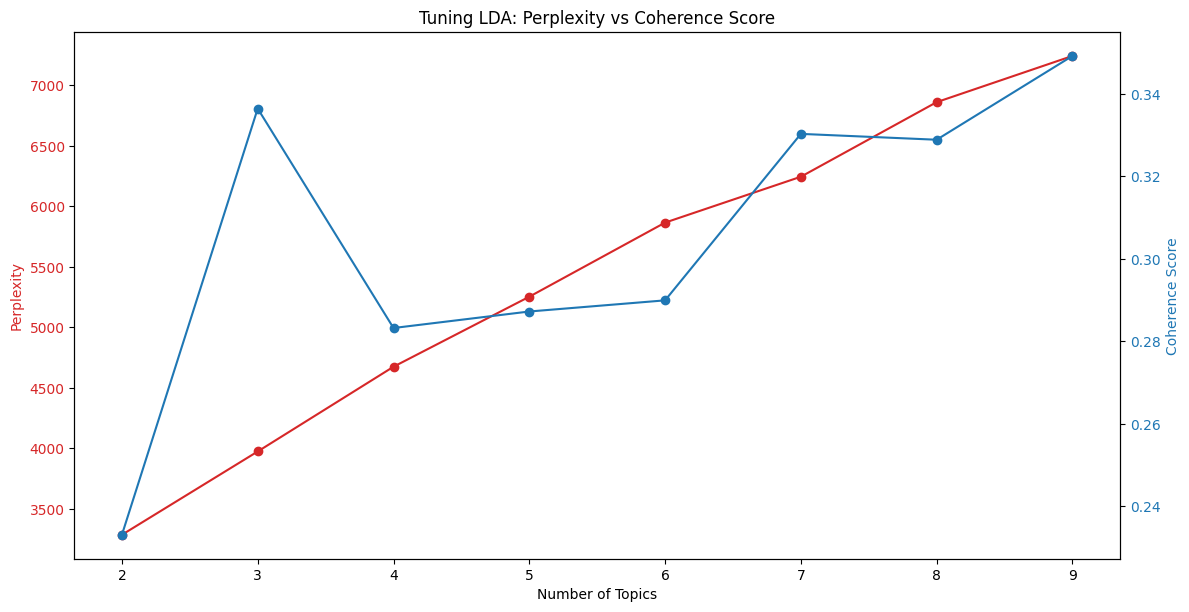

Topic 1:
pago recepcion falta administrativo servicios proveedores acto conforme pagos directo
Topic 2:
funciones cuentas falta control segregacion sistemas debilidades sistema informacion usuarios
Topic 3:
bienes uso inventario falta control registro bodega ausencia inexistencia personal
Topic 4:
entrega canastas beneficiarios falta alimentos multas ausencia cajas datos control
Topic 5:
falta compra administrativos seleccion actos sanitaria residencias residencia sanitarias jornada
Topic 6:
respaldo documentacion falta manual gastos ausencia remuneraciones procedimiento procedimientos antecedentes
Topic 7:
manuales rendiciones procedimientos documentos falta pago calculo plazo gastos cheques
Topic 8:
falta bancarias conciliaciones cuenta supervision cumplimiento corriente conciliacion bancaria contable
Topic 9:
falta incumplimiento plan terreno fiscal inspeccion regional parte informacion fijo


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
import gensim
import gensim.corpora as corpora

# Example DataFrame
# df = pd.DataFrame({
#     'Document': ["text of document 1", "text of document 2", "text of document 3", ...]
# })
df['tokenized_text_1'] = df['tokenized_text'].apply(lambda x: ' '.join(x))
# Step 1: Convert documents into a document-term matrix using CountVectorizer
count_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
count_data = count_vectorizer.fit_transform(df['tokenized_text_1'])

# Step 2: Tune the number of topics using Perplexity and Coherence Score
num_topics_range = range(2, 10)  # Range of topics to try
perplexity_scores = []
coherence_scores = []

# Prepare the data for gensim coherence calculation
texts = [doc.split() for doc in df['tokenized_text_1']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

for num_topics in num_topics_range:
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(count_data)

    # Calculate Perplexity
    perplexity = lda_model.perplexity(count_data)
    perplexity_scores.append(perplexity)

    # Calculate Coherence Score using gensim
    lda_gensim = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)

    print(f"Number of Topics: {num_topics}, Perplexity: {perplexity:.3f}, Coherence Score: {coherence_score:.3f}")

# Step 3: Plot the results to visualize optimal number of topics
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(num_topics_range, perplexity_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Coherence Score', color=color)  # we already handled the x-label with ax1
ax2.plot(num_topics_range, coherence_scores, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Tuning LDA: Perplexity vs Coherence Score')
plt.show()

# Step 4: Choose the optimal number of topics (based on Perplexity and Coherence)
optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]

# Final LDA Model with the chosen number of topics
lda_final = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
lda_final.fit(count_data)

# Display top words for each topic
n_top_words = 10
feature_names = count_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda_final.components_):
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Optional: Add topic distribution to the DataFrame
df['Topic'] = lda_final.transform(count_data).argmax(axis=1)

In [ ]:
TF_IDF = pd.DataFrame(count_data.toarray(), columns=count_vectorizer.get_feature_names_out())

In [ ]:
TF_IDF.describe().T

,count,mean,std,min,25%,50%,75%,max
aa,24961.0,0.000038,0.004197,0.0,0.0,0.0,0.0,0.487198
abajo,24961.0,0.000025,0.002884,0.0,0.0,0.0,0.0,0.398703
abandonadas,24961.0,0.000040,0.004586,0.0,0.0,0.0,0.0,0.603512
abandonados,24961.0,0.000042,0.003854,0.0,0.0,0.0,0.0,0.351564
abandono,24961.0,0.000316,0.012324,0.0,0.0,0.0,0.0,0.625785
...,...,...,...,...,...,...,...,...
zona,24961.0,0.000477,0.013424,0.0,0.0,0.0,0.0,0.636229
zonal,24961.0,0.000042,0.003840,0.0,0.0,0.0,0.0,0.358911
zonas,24961.0,0.000501,0.014478,0.0,0.0,0.0,0.0,0.629659
zpl,24961.0,0.000084,0.005922,0.0,0.0,0.0,0.0,0.459717


In [ ]:
desxcribed_TF_IDF = pd.DataFrame(TF_IDF.describe().T)
desxcribed_TF_IDF.head()

,count,mean,std,min,25%,50%,75%,max
aa,24961.0,0.000038,0.004197,0.0,0.0,0.0,0.0,0.487198
abajo,24961.0,0.000025,0.002884,0.0,0.0,0.0,0.0,0.398703
abandonadas,24961.0,0.000040,0.004586,0.0,0.0,0.0,0.0,0.603512
abandonados,24961.0,0.000042,0.003854,0.0,0.0,0.0,0.0,0.351564
abandono,24961.0,0.000316,0.012324,0.0,0.0,0.0,0.0,0.625785


In [ ]:
TF_IDF['AVG'] = TF_IDF.mean(axis=1)
TF_IDF.head()

,aa,abajo,abandonadas,abandonados,abandono,abastecidas,abastecimiento,abatimiento,abierta,abiertas,...,zapahuira,zarpa,zinc,zoit,zona,zonal,zonas,zpl,zumba,AVG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000439
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000415
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000322
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000383
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000479


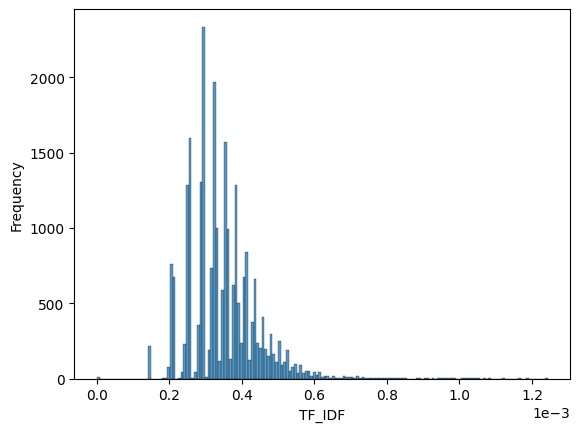

In [ ]:
sns.histplot(TF_IDF['AVG'])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('TF_IDF')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import seaborn as sns
# Plotting t-SNE Components
plt.figure(figsize=(10, 8))
sns.scatterplot(x = 'tsne_1', y='tsne_2', data = df, hue='Topic')

# Title and labels
plt.title('t-SNE Plot of Spanish Documents (fastText)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show plot
plt.show()

ValueError: Could not interpret value `tsne_1` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x800 with 0 Axes>

In [ ]:
!pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.2 MB/s eta 0:00:00


In [ ]:
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from pyLDAvis import gensim_models

texts = df['Titulo Observacion'].values

In [ ]:
lda_gensim_1 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=9, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_gensim_1.print_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.035*"falta" + 0.031*"informacion" + 0.025*"sistema" + 0.023*"fiscal" + 0.021*"control" + 0.019*"terreno" + 0.016*"calidad" + 0.014*"registro" + 0.013*"publicacion" + 0.012*"deficiencias"'),
 (1,
  '0.024*"bienes" + 0.023*"falta" + 0.021*"uso" + 0.019*"bancarias" + 0.019*"control" + 0.018*"inventario" + 0.018*"conciliaciones" + 0.017*"debilidades" + 0.015*"seguridad" + 0.014*"registro"'),
 (2,
  '0.046*"obra" + 0.024*"contrato" + 0.020*"falta" + 0.018*"programa" + 0.015*"cumplimiento" + 0.015*"trabajos" + 0.012*"ejecucion" + 0.012*"trabajo" + 0.011*"plan" + 0.010*"demora"'),
 (3,
  '0.020*"cuenta" + 0.019*"cgr" + 0.018*"geo" + 0.018*"fondos" + 0.018*"cuentas" + 0.015*"medicamentos" + 0.014*"articulo" + 0.014*"unidad" + 0.013*"riesgo" + 0.013*"equipos"'),
 (4,
  '0.027*"falta" + 0.026*"servicios" + 0.019*"contrato" + 0.018*"fiscalizacion" + 0.017*"administrativo" + 0.017*"supervision" + 0.014*"acto" + 0.013*"resolucion" + 0.012*"ausencia" + 0.009*"condiciones"'),
 (5,
  '0.035*

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_gensim_1, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

doc_vectors = pd.DataFrame(df['doc2vec'].tolist())

# Standardize the vectors
scaler = StandardScaler()
doc_vectors_scaled = scaler.fit_transform(doc_vectors)

# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.1, min_samples=200)  # Adjust `eps` and `min_samples` based on your data
df['Cluster_DB'] = dbscan.fit_predict(doc_vectors_scaled)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
